# Importing Libraries

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn import datasets

import plotly.graph_objs as go
import ipywidgets as widgets

pd.set_option("display.max_columns", 50)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Data

In [ ]:
train_url = '/kaggle/input/inf648-curso-de-aprendizaje-automtico/train.csv'
train_url = 'https://raw.githubusercontent.com/josetorresob/INF648/master/bank-additional-full.csv'
dataset=pd.read_csv(train_url, delimiter=";")
print(dataset.shape)
dataset.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
dataset.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [ ]:
categorical_variables = dataset.loc[:, dataset.dtypes == object].columns
print("Variables categóricas: ", categorical_variables, "\n")
li_categ = []
for c in categorical_variables:
  li_categ.append(pd.unique(dataset[c]))

print("List unique categorical: \n")
li_categ

Variables categóricas:  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object') 

List unique categorical: 



[array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
        'retired', 'management', 'unemployed', 'self-employed', 'unknown',
        'entrepreneur', 'student'], dtype=object),
 array(['married', 'single', 'divorced', 'unknown'], dtype=object),
 array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
        'professional.course', 'unknown', 'university.degree',
        'illiterate'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'yes', 'unknown'], dtype=object),
 array(['no', 'yes', 'unknown'], dtype=object),
 array(['telephone', 'cellular'], dtype=object),
 array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
        'sep'], dtype=object),
 array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object),
 array(['nonexistent', 'failure', 'success'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [ ]:
train_url = '/kaggle/input/inf648-curso-de-aprendizaje-automtico/train.csv'
train_url = 'https://raw.githubusercontent.com/josetorresob/INF648/master/train.csv'
dataset=pd.read_csv(train_url)
print(dataset.shape)
dataset.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Pre Processing

In [ ]:
def deuda_union(x,y):
    if (x==2 & y==2):
      return "2"
    elif ((x==0 & y==1) | (x==1 & y==0) | (x==1 & y==1) | (x==2 & y==1) | (x==1 & y==2) ):
      return "1"
    else:
      return "0"

In [ ]:
to_remove_column = set([])#set(["ID", "pdias","Estado Civil", "Trabajo" ,"Contacto",  "Llamadas previas", "Grado Educacion"])

def preprocess_dataset(dataset):
  preprocessed_dataset = dataset.copy()
  #preprocessed_dataset.dropna(axis=1, thresh=int(0.7*len(preprocessed_dataset)), inplace=True)

  if to_remove_column.issubset(set(preprocessed_dataset.columns)):
    preprocessed_dataset.drop(to_remove_column, axis=1, inplace=True)

  # preprocessed_dataset["Mes"].replace(to_replace =["enero"], value=0,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["febrero"], value=1,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["marzo"], value=2,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["abril"], value=3,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["mayo"], value=4,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["junio"], value=5,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["julio"], value=6,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["agosto"], value=7,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["septiembre"], value=8,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["octubre"], value=9,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["noviembre"], value=10,inplace =True)
  # preprocessed_dataset["Mes"].replace(to_replace =["diciembre"], value=11,inplace =True)

  # preprocessed_dataset["Dia Semana"].replace(to_replace =["lunes"], value=0,inplace =True)
  # preprocessed_dataset["Dia Semana"].replace(to_replace =["martes"], value=1,inplace =True)
  # preprocessed_dataset["Dia Semana"].replace(to_replace =["miercoles"], value=2,inplace =True)
  # preprocessed_dataset["Dia Semana"].replace(to_replace =["jueves"], value=3,inplace =True)
  # preprocessed_dataset["Dia Semana"].replace(to_replace =["viernes"], value=4,inplace =True)
  # preprocessed_dataset["Dia Semana"].replace(to_replace =["sabado"], value=4,inplace =True)
  # preprocessed_dataset["Dia Semana"].replace(to_replace =["domingo"], value=4,inplace =True)

  # preprocessed_dataset["Grado Educacion"] = preprocessed_dataset["Grado Educacion"].replace(
  #       regex=[r'^primaria.*$', 'analfabeto', "desconocido"], value='primaria'
  # ).replace(regex=['tecnico', 'universitario'], value='superior')

  # educacion_dummies = pd.get_dummies(preprocessed_dataset["Grado Educacion"], prefix="Grado Educacion").iloc[:,1:]
  # preprocessed_dataset = pd.concat([preprocessed_dataset, educacion_dummies], axis=1)

  # preprocessed_dataset["Trabajo"] = preprocessed_dataset["Trabajo"].replace(
  #     to_replace =["emprendedor","propio-empleado", "desconocido", "ejecutivo"], value="autonomo"
  # ).replace(
  #     to_replace =["administrador","operador-industria","tecnico","servicio"], value="asalariado", 
  # ).replace(
  #     to_replace =["ama-de-llaves","unemployed","retirado","estudiante"], value="no-asalariado"
  # )

  #Trabajo_dummies = pd.get_dummies(preprocessed_dataset["Trabajo"], prefix="Trabajo").iloc[:,1:]
  #preprocessed_dataset = pd.concat([preprocessed_dataset, Trabajo_dummies], axis=1)

  #if "Trabajo" in preprocessed_dataset:
    #reprocessed_dataset.drop(["Trabajo"], axis=1, inplace=True)

  #preprocessed_dataset["Estado Civil"].replace(to_replace= ["divorciado", "desconocido"], value="otro", inplace=True)

  #Estadocivil_dummies = pd.get_dummies(preprocessed_dataset["Estado Civil"], prefix="Estado Civil").iloc[:,1:]
  #preprocessed_dataset = pd.concat([preprocessed_dataset, Estadocivil_dummies], axis=1)

  #if "Estado Civil" in preprocessed_dataset:
    #preprocessed_dataset.drop(["Estado Civil"], axis=1, inplace=True)

  # preprocessed_dataset["Dueda Casa"].replace({"no": "0", "si": "1", "desconocido":"2"}, inplace=True)
  # preprocessed_dataset["Deuda Personal"].replace({"no": "0", "si": "1", "desconocido":"2"}, inplace=True)
  # preprocessed_dataset["Deuda"]  = preprocessed_dataset.apply(lambda x: deuda_union(int(x["Dueda Casa"]),int(x["Deuda Personal"])), axis=1)

  # preprocessed_dataset.drop(["Dueda Casa", "Deuda Personal"], axis=1, inplace=True)

  label_encoder = LabelEncoder()

  for column in preprocessed_dataset.columns:
    if not pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      preprocessed_dataset[column] = label_encoder.fit_transform(preprocessed_dataset[column].astype(str))

      print("Para la columna '{}', la codificación fue: {}".format(column, dict(enumerate(label_encoder.classes_))))
  
  return preprocessed_dataset

In [ ]:
#Transformamos los datos a valores numéricos
preprocessed_dataset = preprocess_dataset(dataset)

print("\n >", "-"*10, "Tipo de datos", "-"*10, "< \n")
preprocessed_dataset.dtypes

Para la columna 'job', la codificación fue: {0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid', 4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services', 8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'}
Para la columna 'marital', la codificación fue: {0: 'divorced', 1: 'married', 2: 'single', 3: 'unknown'}
Para la columna 'education', la codificación fue: {0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}
Para la columna 'default', la codificación fue: {0: 'no', 1: 'unknown', 2: 'yes'}
Para la columna 'housing', la codificación fue: {0: 'no', 1: 'unknown', 2: 'yes'}
Para la columna 'loan', la codificación fue: {0: 'no', 1: 'unknown', 2: 'yes'}
Para la columna 'contact', la codificación fue: {0: 'cellular', 1: 'telephone'}
Para la columna 'month', la codificación fue: {0: 'apr', 1: 'aug', 2: 'dec', 3: 'jul', 4: 'jun', 5: 'mar', 6: 'may', 7: 'nov', 8: 'oct',

age                 int64
job                 int64
marital             int64
education           int64
default             int64
housing             int64
loan                int64
contact             int64
month               int64
day_of_week         int64
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
dtype: object

In [ ]:
preprocessed_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [ ]:
indices_trainval, indices_test = train_test_split(dataset, test_size = 0.2, random_state = 0)
(indices_trainval.shape, indices_test.shape)

((32950, 21), (8238, 21))

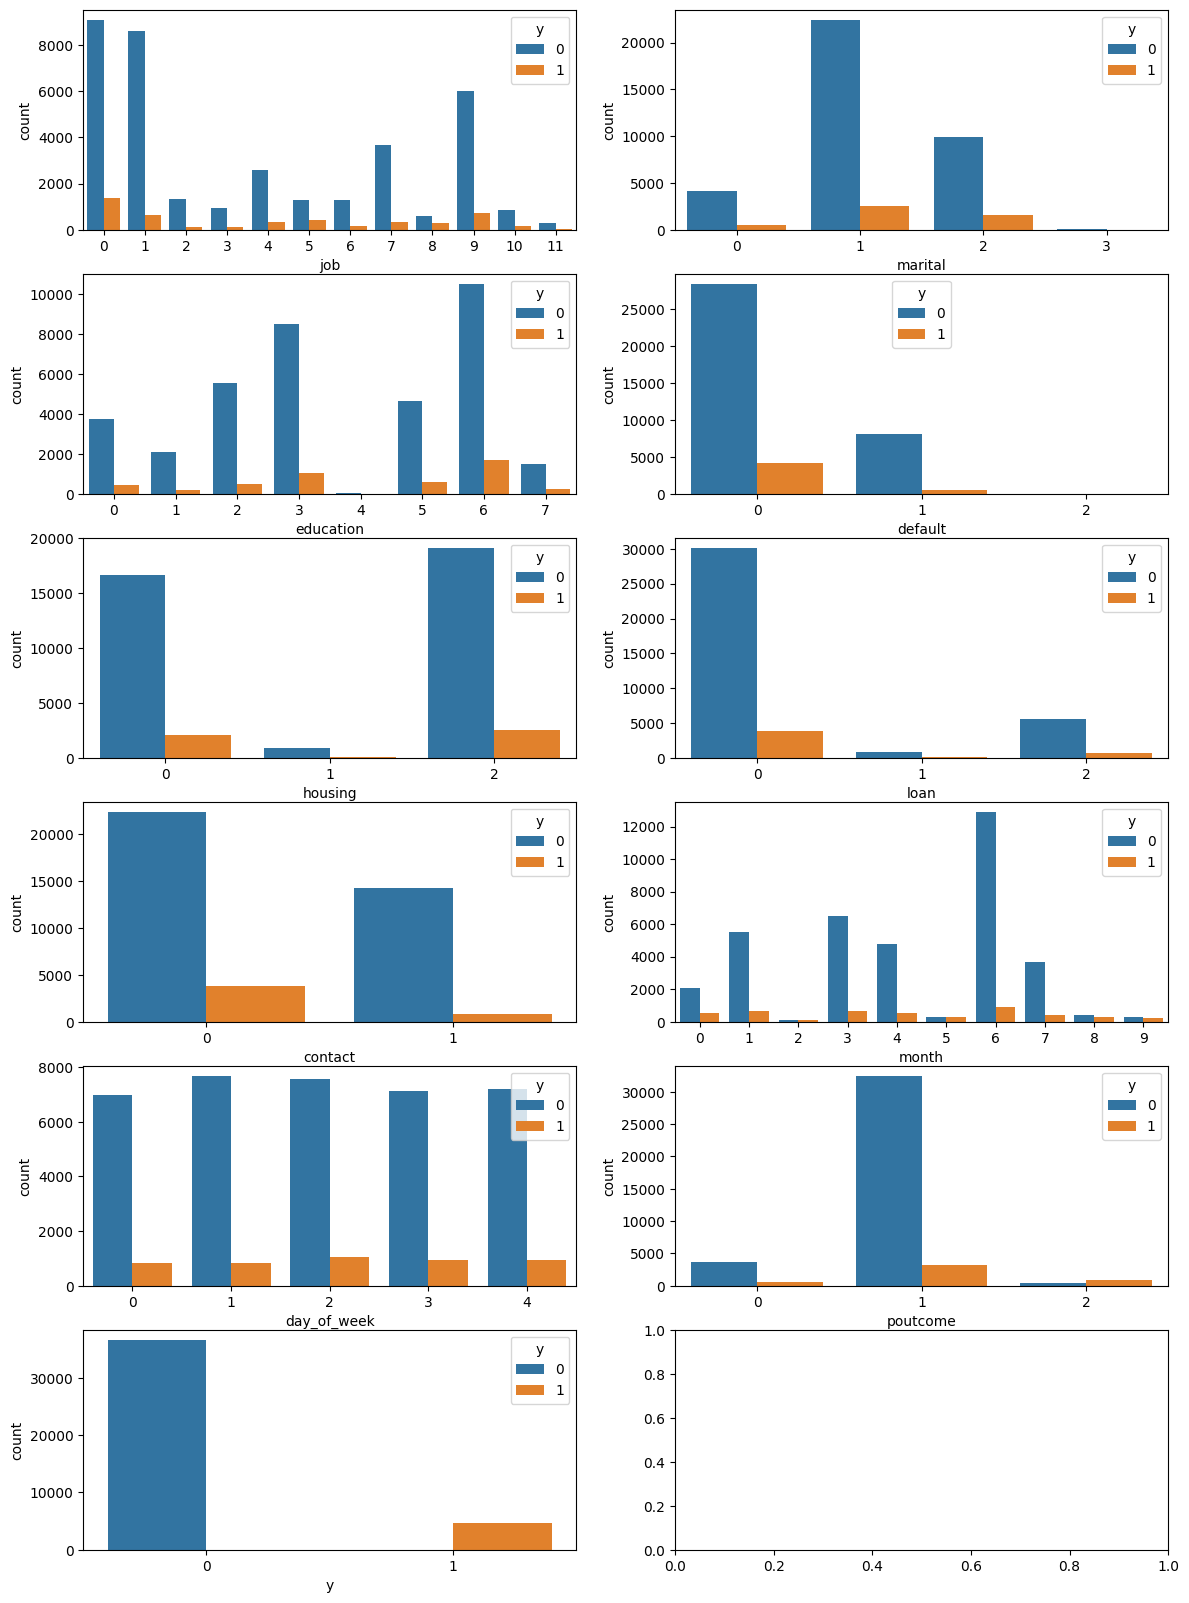

In [ ]:
fig,axes = plt.subplots(6,2,figsize=(14,20))
for idx,cat_col in enumerate(categorical_variables):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=preprocessed_dataset,hue='y',ax=axes[row,col])

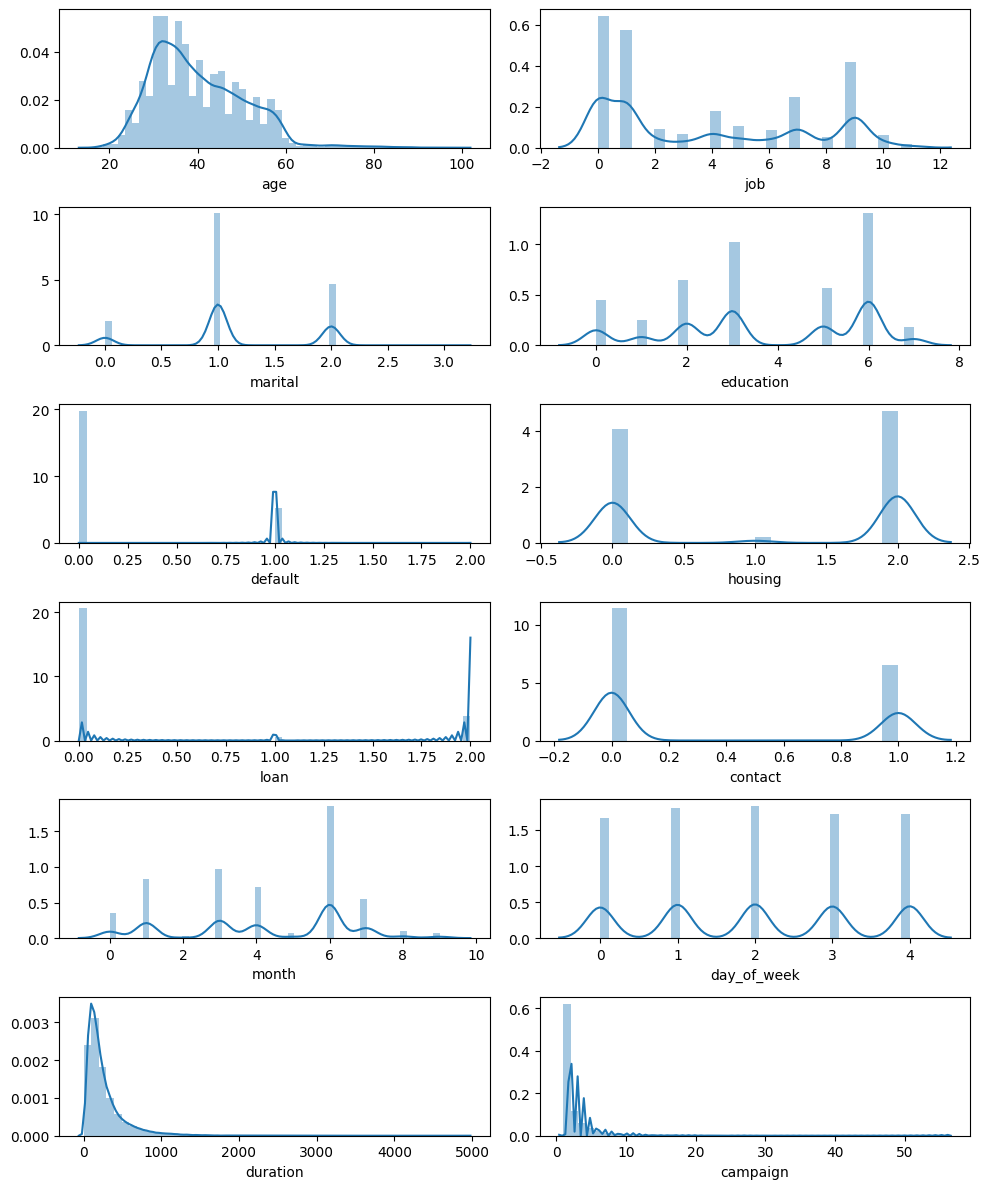

In [ ]:
plt.style.use("default")
#Ver los histogramas por cada columna del preprocessed_dataset
width = 10
height = 12

figure, axes = plt.subplots(nrows=6, ncols=2, figsize=(width, height))

for column, axe in zip(preprocessed_dataset, axes.flatten()):
    sns.distplot(preprocessed_dataset[column], ax=axe)
    
plt.tight_layout()

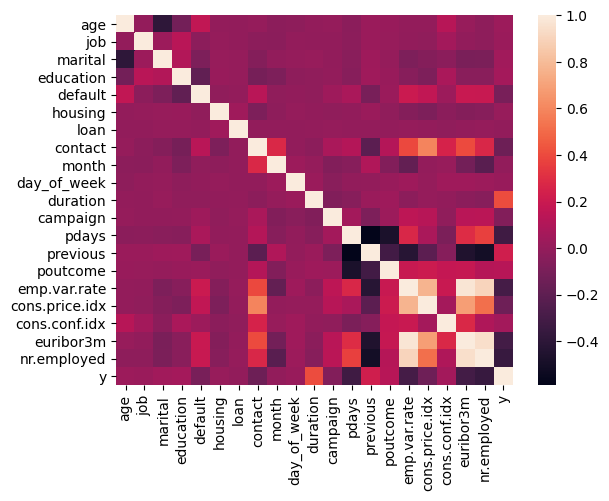

In [ ]:
correlation_variables = preprocessed_dataset.corr()
correlation_columns = correlation_variables.columns.values
sns.heatmap(correlation_variables, 
            xticklabels=correlation_columns,
            yticklabels=correlation_columns)

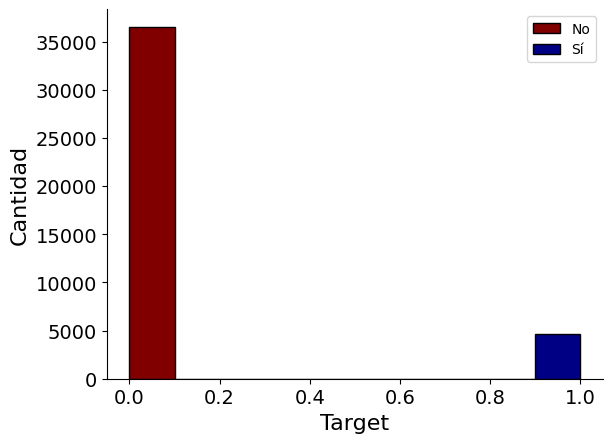

In [ ]:
from matplotlib.patches import Rectangle

N, bins, patches = plt.hist(preprocessed_dataset["y"], ec="k")

cmap = plt.get_cmap('jet')
low = cmap(1.1)
high = cmap(1)


for i in range(0,4):
    patches[i].set_facecolor(low)
for i in range(4,10):
    patches[i].set_facecolor(high)

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,high]]

labels= ["No","Sí"]
plt.legend(handles, labels)


plt.xlabel("Target", fontsize=16)  
plt.ylabel("Cantidad", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

In [ ]:
def create_bins(df, column, bins_dict):
  bins_list = bins_dict["bins_list"]
  bins_number = bins_dict["bins_number"]

  if (bins_list):
    data_for_bins = pd.cut(df[column], bins=bins_list, precision=0, duplicates="drop")

  else:
    data_for_bins = df[column]

    min_value = data_for_bins.min()
    max_value = data_for_bins.max()

    repetitions_of_min_value = len(data_for_bins[data_for_bins == min_value])
    repetitions_of_max_value = len(data_for_bins[data_for_bins == max_value])

    if repetitions_of_min_value > 1:
      #Si el valor mínimo se repite entonces agregamos un valor mínimo falso para balancear mejor los quantiles
      data_for_bins = data_for_bins.append(pd.Series([min_value - 1]), ignore_index=True)

    if repetitions_of_max_value > 1:
      #Si el valor máximo se repite entonces agregamos un valor máximo falso para balancear mejor los quantiles
      data_for_bins = data_for_bins.append(pd.Series([max_value + 1]), ignore_index=True)
    
    #Se usa duplicates="drop" por si los límites de los bins se repiten. No sucederá este caso para el primer y último bin 
    quantiles = pd.qcut(data_for_bins, q=bins_number, precision=0, duplicates="drop")
    
    data_for_bins = quantiles

    if repetitions_of_max_value > 1:
      #Eliminamos el valor máximo que introducimos
      data_for_bins = data_for_bins[:-1]
    
    if repetitions_of_min_value > 1:
      #Eliminamos el valor máximo que introducimos
      data_for_bins = data_for_bins[:-1]

  dictionary_of_intervals = dict()

  for index, interval in enumerate(data_for_bins.cat.categories):
    dictionary_of_intervals[interval] = int(index)
    
  df.reset_index(drop=True, inplace=True)

  bins_column = "Bins_for_" + column

  #df.drop([column], axis=1, inplace=True)

  df[bins_column + "_index"] = data_for_bins

  df.replace({bins_column + "_index": dictionary_of_intervals}, inplace=True)
  print("Bins for "+ column +" Created")

In [ ]:
bins_dict = {
    "Edad": {"bins_number": 0, "bins_list": [0,20,30,40,50,70,100]},
	  "Duracion": {"bins_number": 5, "bins_list": []},
	  "Llamadas": {"bins_number": 4, "bins_list": []},
	  #"tasaVarEmp": {"bins_number": 5, "bins_list": []},
	 # "indicador consumidor precio": {"bins_number": 5, "bins_list": []},
	  #"indicador confianza consumidor": {"bins_number": 5, "bins_list": []},
	  "indicador macro": {"bins_number": 5, "bins_list": []}
	  #"ind. Cuartil emp": {"bins_number": 5, "bins_list": []}
}

In [ ]:
for column, bins_list in bins_dict.items():
  create_bins(preprocessed_dataset, column, bins_list)

Bins for Edad Created
Bins for Duracion Created
Bins for Llamadas Created
Bins for indicador macro Created


In [ ]:
preprocessed_dataset.head()

,Edad,Credito por Default,Mes,Dia Semana,Duracion,Llamadas,presultado,tasaVarEmp,indicador consumidor precio,indicador confianza consumidor,indicador macro,ind. Cuartil emp,Target,Deuda,Bins_for_Edad_index,Bins_for_Duracion_index,Bins_for_Llamadas_index,Bins_for_indicador macro_index
0,30,1,7,0,160,1,2,1.4,93.444,-36.1,4.970,5228.1,0,1,1,2,0,4
1,27,1,4,4,472,6,1,-1.8,92.893,-46.2,1.250,5099.1,0,1,1,4,3,0
2,38,0,4,3,152,2,2,-1.8,92.893,-46.2,1.266,5099.1,0,0,2,2,1,0
3,33,1,10,2,419,5,2,-0.1,93.200,-42.0,4.120,5195.8,0,1,2,4,3,1
4,39,1,3,0,121,2,2,-1.8,93.075,-47.1,1.405,5099.1,0,1,2,1,1,1


# Train Test

In [ ]:
test_url = '/kaggle/input/inf648-curso-de-aprendizaje-automtico/test.csv'
test_url = 'https://raw.githubusercontent.com/josetorresob/INF648/master/test.csv'
dataset_test=pd.read_csv(test_url)
print(dataset_test.shape)
dataset_test.head()

(8650, 21)


,ID,Edad,Trabajo,Estado Civil,Grado Educacion,Credito por Default,Dueda Casa,Deuda Personal,Contacto,Mes,Dia Semana,Duracion,Llamadas,pdias,Llamadas previas,presultado,tasaVarEmp,indicador consumidor precio,indicador confianza consumidor,indicador macro,ind. Cuartil emp
0,A01614,33,servicio,casado,secundaria,desconocido,no,no,telefono,mayo,viernes,483,3,999,0,inexistente,1.1,93.994,-36.4,4.855,5191.0
1,A24124,34,tecnico,soltero,desconocido,no,no,no,telefono,noviembre,lunes,101,1,999,0,inexistente,-0.1,93.200,-42.0,4.191,5195.8
2,A12511,49,operador-industria,casado,primaria.4a,no,no,si,telefono,julio,lunes,256,15,999,0,inexistente,1.4,93.918,-42.7,4.960,5228.1
3,A10200,34,administrador,soltero,secundaria,no,si,no,telefono,junio,jueves,161,2,999,0,inexistente,1.4,94.465,-41.8,4.958,5228.1
4,A07338,42,servicio,casado,tecnico,no,no,no,telefono,mayo,viernes,177,1,999,0,inexistente,1.1,93.994,-36.4,4.864,5191.0


In [ ]:
#Transformamos los datos a valores numéricos
preprocessed_dataset_test = preprocess_dataset(dataset_test)

print("\n >", "-"*10, "Tipo de datos", "-"*10, "< \n")
preprocessed_dataset_test.dtypes

Para la columna 'Credito por Default ', la codificación fue: {0: 'desconocido', 1: 'no', 2: 'si'}
Para la columna 'presultado', la codificación fue: {0: 'exito', 1: 'fracaso', 2: 'inexistente'}
Para la columna 'Deuda', la codificación fue: {0: '0', 1: '1', 2: '2'}

 > ---------- Tipo de datos ---------- < 



Edad                                int64
Credito por Default                 int64
Mes                                 int64
Dia Semana                          int64
Duracion                            int64
Llamadas                            int64
presultado                          int64
tasaVarEmp                        float64
indicador consumidor precio       float64
indicador confianza consumidor    float64
indicador macro                   float64
ind. Cuartil emp                  float64
Deuda                               int64
dtype: object

In [ ]:
preprocessed_dataset_test.head()

,Edad,Credito por Default,Mes,Dia Semana,Duracion,Llamadas,presultado,tasaVarEmp,indicador consumidor precio,indicador confianza consumidor,indicador macro,ind. Cuartil emp,Deuda
0,33,0,4,4,483,3,2,1.1,93.994,-36.4,4.855,5191.0,1
1,34,1,10,0,101,1,2,-0.1,93.200,-42.0,4.191,5195.8,1
2,49,1,6,0,256,15,2,1.4,93.918,-42.7,4.960,5228.1,0
3,34,1,5,3,161,2,2,1.4,94.465,-41.8,4.958,5228.1,0
4,42,1,4,4,177,1,2,1.1,93.994,-36.4,4.864,5191.0,1


In [ ]:
for column, bins_list in bins_dict.items():
  create_bins(preprocessed_dataset_test, column, bins_list)

Bins for Edad Created
Bins for Duracion Created
Bins for Llamadas Created
Bins for indicador macro Created


## Model Parameters


In [ ]:
TC_parameters = {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 100}
RF_pamameters = {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 500}
XGC_pamameters =  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500, 'scale_pos_weight': 7.903}

LGBM_parameters = {
    'bagging_freq': 5, #5
    'bagging_fraction': 0.4, #0.4
    'boost_from_average':'false',
    'min_child_samples': 30,
    'boost': 'gbdt',
    'feature_fraction': 0.5, #0.05
    'learning_rate': 0.01, #0.01
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80, #80
    'min_sum_hessian_in_leaf': 10, #10
    'num_leaves': 32, #13
    'num_threads': 16, 
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    "is_unbalance":True,
    "random_state":1234,
}

In [ ]:
def run_model(train_df, test_df, target_col, LGBM_parameters):
  features  = list(train_df.columns)
  features.remove(target_col)
  target = train_df[target_col]
  folds  = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
  oof    = np.zeros(len(train_df))
  predictions = np.zeros(len(test_df))
  feature_importance_df = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
      print("Fold {}".format(fold_))
      trn_data = lgbm.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
      val_data = lgbm.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

      num_round = 10000
      clf = lgbm.train(LGBM_parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
      oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
      
      fold_importance_df = pd.DataFrame()
      fold_importance_df["Feature"] = features
      fold_importance_df["importance"] = clf.feature_importance()
      fold_importance_df["fold"] = fold_ + 1
      feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
      
      predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

  print("\n CV score: {:<8.5f}".format(roc_auc_score(target, oof)))   
  return predictions, feature_importance_df

In [ ]:
train_df = preprocessed_dataset.copy()
test_df  = preprocessed_dataset_test.copy()

predictions, fi_df = run_model(train_df, test_df, "Target", LGBM_parameters) # 0.94983 

Fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.963855	valid_1's auc: 0.950484
Early stopping, best iteration is:
[807]	training's auc: 0.961502	valid_1's auc: 0.950763
Fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.96326	valid_1's auc: 0.953173
Early stopping, best iteration is:
[897]	training's auc: 0.962106	valid_1's auc: 0.953383
Fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.964612	valid_1's auc: 0.946738
Early stopping, best iteration is:
[870]	training's auc: 0.963036	valid_1's auc: 0.946973
Fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.963485	valid_1's auc: 0.950411
[2000]	training's auc: 0.971296	valid_1's auc: 0.949945
Early stopping, best iteration is:
[1046]	training's auc: 0.964023	valid_1's auc: 0.950579
Fold 4
Training until validation scores don't improve for 1000 rounds.
[1000

In [ ]:
def features_plot(feature_importance_df):
  cols = (feature_importance_df[["Feature", "importance"]]
          .groupby("Feature")
          .mean()
          .sort_values(by="importance", ascending=False)[:150].index)
  best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

  plt.figure(figsize=(14,28))
  sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
  plt.title('Features importance (averaged/folds)')
  plt.tight_layout()

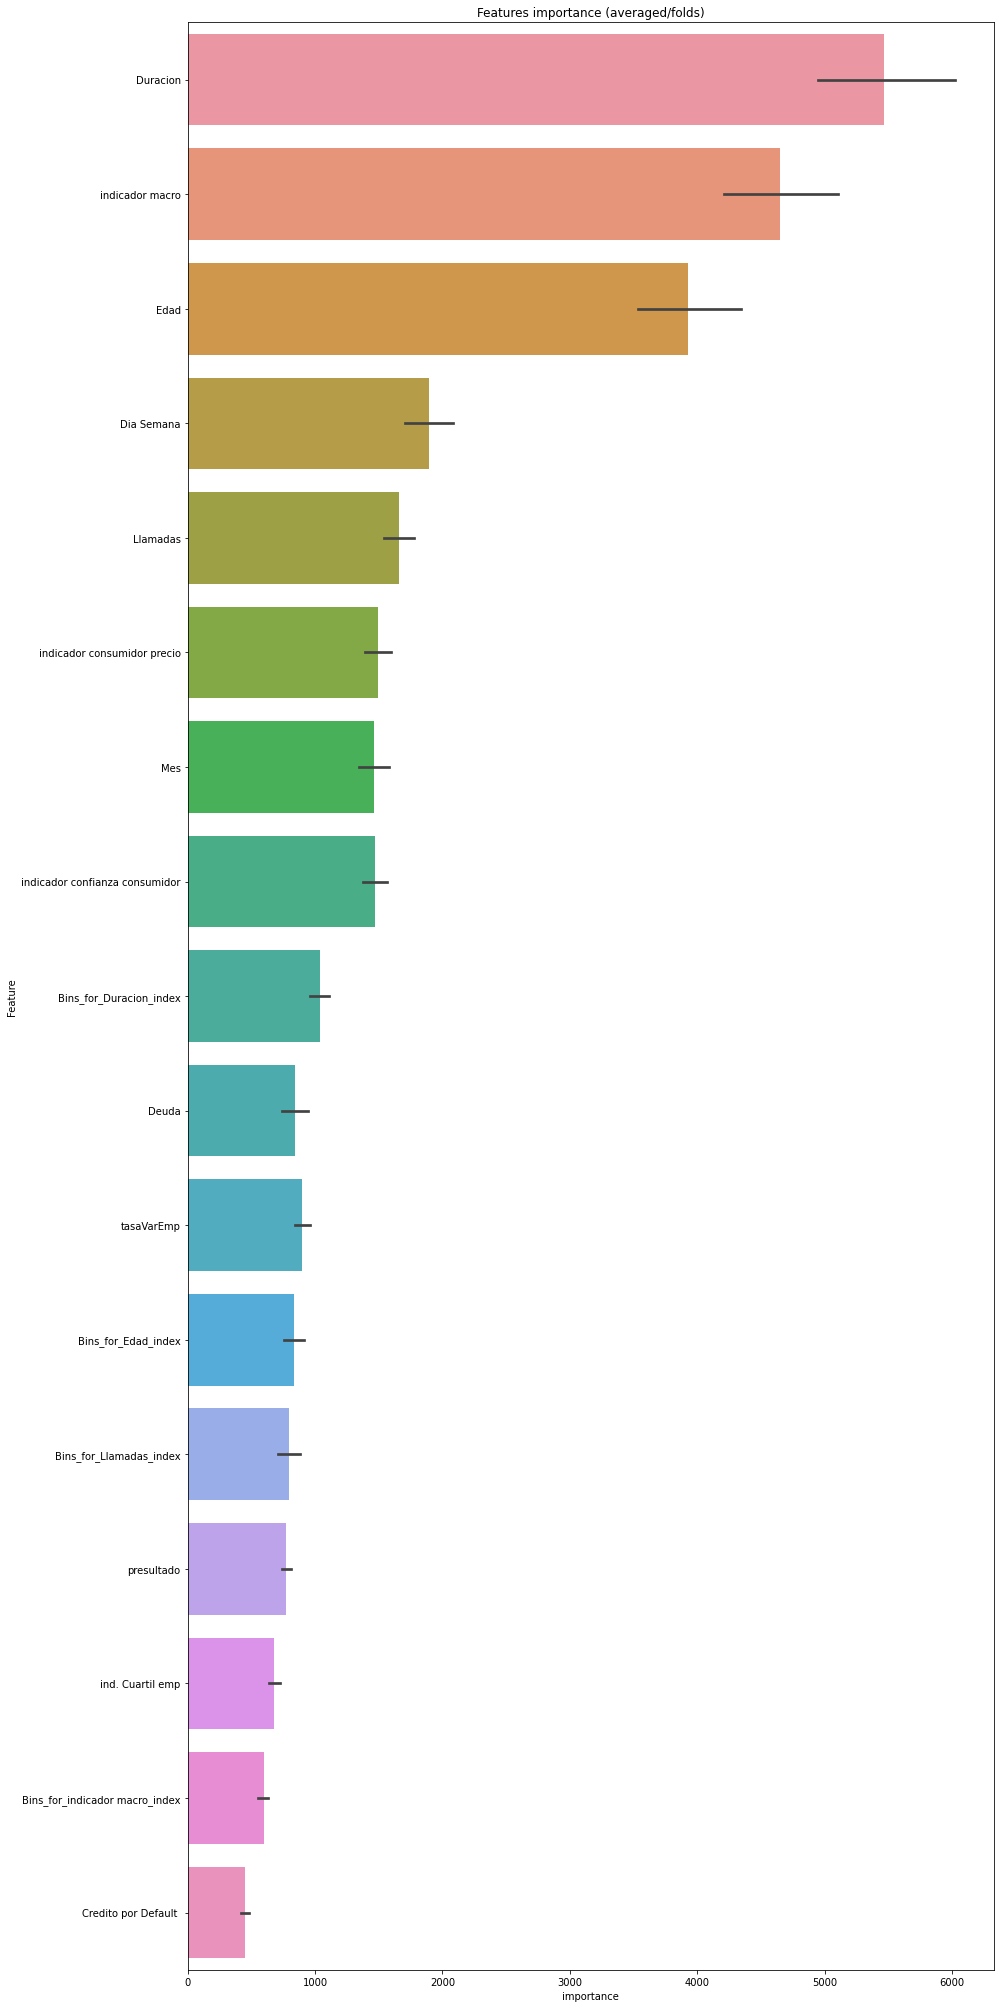

In [ ]:
features_plot(fi_df)

# Generate Submission

In [ ]:
submission = pd.DataFrame({'ID':dataset_test.ID, 'Target':predictions})

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
#files.download('submission.csv')